In [3]:
from huggingface_hub import login
#from datasets import load_dataset, Dataset
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
from transformers import XLMRobertaModel, XLMRobertaTokenizerFast
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# authentication with huggingface
# create token at https://huggingface.co/settings/tokens (create as read)
# token should be stored locally, so technically login is only needed one time
login()

In [5]:
# # download specific dataset files; entire archive is only ~250 mb
# articles = load_dataset("Cofacts/line-msg-fact-check-tw", "articles") # article contents and some meta info
# article_replies = load_dataset("Cofacts/line-msg-fact-check-tw", "article_replies") # 'join table' for articles and replies with added meta info

# open from csv
articles = pd.read_csv('./data/articles.csv',lineterminator='\n')
article_replies = pd.read_csv('./data/article_replies.csv')

In [6]:
art_rep_df = pd.merge(articles, article_replies, left_on="id", right_on="articleId", how="left")
art_rep_df.head()
# replyType is the label assigned to the article by the human editor

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
0,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,14h550ymn3m3u,6oo8DYMBv5it-Cx_8405,6892d0026181e95d034bf8781025afbf395d57cc88ac05...,0.0,3.0,RUMOR,WEBSITE,NORMAL,2022-09-05T10:40:41.789Z,2022-09-05T10:40:41.789Z
1,326xjpkjbf01i,TEXT,NORMAL,https://youtu.be/xK9NzL3PkdE,0.0,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.634Z,243b5897c14f02fb5b92a9e4f4cc39d5fb84ff16173add...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班\n\n2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,oupi0eu9aocr,MYotCYMBv5it-Cx_gIpH,fc9652aa205dab75e19ecff420945e95aa3909a54b0d9a...,0.0,1.0,OPINIONATED,WEBSITE,NORMAL,2022-09-04T15:45:20.464Z,2022-09-04T15:45:20.464Z
3,my5ep5z69tql,TEXT,NORMAL,你好👱🏻‍♀️\n\n簡單跟你說一下公司工作內容：\n我們是做購物系統訂單的工作，主要就是增...,1.0,2022-08-11T20:53:15.644Z,2022-08-11T20:53:15.644Z,2022-09-07T11:02:00.344Z,8a8a319bea0b3bff580d8507ae6470ba37e87791171886...,RUMORS_LINE_BOT,...,my5ep5z69tql,y22DlmsBFV14knB4ErTJ,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:59:48.921Z,2022-09-07T22:59:48.921Z
4,3dnh713ikpf3c,TEXT,NORMAL,先和你簡單介紹\n我們誠徵線上打工小幫手\n工作內容有：聽寫打字、頁面排版、商品評論刷流量、...,1.0,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.761Z,47e90b2538a5615b323f50571b77d91f7f105e55684aa1...,RUMORS_LINE_BOT,...,3dnh713ikpf3c,H8Hz4WsBqwaEkHKwtyFm,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T23:00:19.207Z,2022-09-07T23:00:19.207Z


In [7]:
def get_max_length(texts: list):
    max_length = 0
    for t in texts:
        if t:
            max_length = max(max_length, len(t))
    return max_length

def inspect_dist(col: list, threshold = 0):
    if threshold == 0:
        plt.hist(col, bins=100)
        plt.show()
    else:
        plt.hist(col[col <= threshold], bins=100)
        plt.show()
        print(f"Remaining datapoints: {len(col[col <= threshold]) / len(col)}")

In [8]:
art_rep_df[art_rep_df["text"].str.len() == 28]
# NOTE: remove urls

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
1,326xjpkjbf01i,TEXT,NORMAL,https://youtu.be/xK9NzL3PkdE,0.0,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.634Z,243b5897c14f02fb5b92a9e4f4cc39d5fb84ff16173add...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,2ihx6b0hy6reh,TEXT,NORMAL,https://fb.watch/fqyCukx77O/,0.0,2022-09-09T08:30:45.294Z,2022-09-09T08:30:45.294Z,2022-09-09T08:30:45.321Z,67cb002cbd4884b64f03aca3400e67a867b35e3838caa3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,2zvytlna89voa,TEXT,NORMAL,https://youtu.be/EHvxmzP7Mfw,0.0,2022-09-11T00:24:14.167Z,2022-09-11T00:24:14.167Z,2022-09-11T00:24:14.197Z,1b8841d66c76e5ebbce83a71ddfa61fea29c32a736218f...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,32745wxu27y2q,TEXT,NORMAL,https://youtu.be/BSh2Lj_OrDs,0.0,2022-09-11T06:24:59.763Z,2022-09-11T06:24:59.763Z,2022-09-11T06:24:59.791Z,9fdd5c5952dbbe145c4f00ca018fe0979e5875fbac45fe...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,1ppbai7d2l96o,TEXT,NORMAL,https://youtu.be/3nX_ctdukOI,0.0,2022-09-11T12:29:43.754Z,2022-09-11T12:29:43.754Z,2022-09-11T12:29:43.786Z,5e19fe6083cf02075ff2e022e526a4b09d4958780174d3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168960,h9io4zcc5wbg,TEXT,NORMAL,了解 先自我介紹一下 我是淞瑋包裝材料行徵工代表：葉佳倩,1.0,2024-01-20T06:44:26.971Z,2024-01-20T06:44:26.971Z,2024-01-25T08:35:51.328Z,17295e1f0761fd28c74ff00632d2dd29dbf37baf42f8f0...,RUMORS_LINE_BOT,...,h9io4zcc5wbg,qPc9Qo0BAjOeMOklzqEu,7708d900e0a9d4a92ad69381b1e0782338787e027954ce...,0.0,0.0,RUMOR,WEBSITE,NORMAL,2024-01-25T20:09:23.249Z,2024-01-25T20:09:23.249Z
169040,3dl8g74u3exnz,TEXT,NORMAL,要去app sotre搜尋COINCENTEL載到桌布喔,0.0,2024-01-26T12:11:53.760Z,2024-01-26T12:11:53.760Z,2024-01-26T12:11:53.777Z,8ab6707dd0821b0605969c1bc0481d3ca0bbc87953c9ee...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169313,22vlxdwzs7l7d,TEXT,NORMAL,https://txp.rs/v/ACr5NfeCEn2,0.0,2024-01-26T06:04:22.281Z,2024-01-26T06:04:22.281Z,2024-01-26T06:04:22.293Z,63318d9d6b88b75fac18d8bdb41a5b38ffa759576210f3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169315,ok8jtnk1pj9g,TEXT,NORMAL,https://youtu.be/UwtXzwckeWQ,0.0,2023-05-18T04:27:21.707Z,2023-05-18T04:27:21.707Z,2024-01-26T07:19:52.516Z,e87d917e34b761d233273ebd5cf339be6c92c0920ceafc...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
no_nans = art_rep_df.dropna(subset=["text", "replyType"])
no_nans.info()
no_nans["replyType"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 89997 entries, 0 to 169901
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       89997 non-null  object 
 1   articleType              89997 non-null  object 
 2   status_x                 89997 non-null  object 
 3   text                     89997 non-null  object 
 4   normalArticleReplyCount  89997 non-null  float64
 5   createdAt_x              89932 non-null  object 
 6   updatedAt_x              89059 non-null  object 
 7   lastRequestedAt          89868 non-null  object 
 8   userIdsha256_x           85464 non-null  object 
 9   appId_x                  89997 non-null  object 
 10  references               89997 non-null  object 
 11  articleId                89997 non-null  object 
 12  replyId                  89997 non-null  object 
 13  userIdsha256_y           89997 non-null  object 
 14  negativeFeedbackCount    8

replyType
RUMOR          47119
NOT_RUMOR      16592
NOT_ARTICLE    15390
OPINIONATED    10896
Name: count, dtype: int64

In [10]:
get_max_length(no_nans["text"])

10000

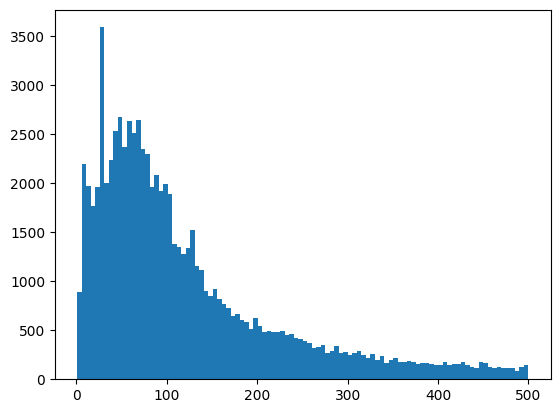

Remaining datapoints: 0.8774514706045757


In [11]:
inspect_dist(no_nans["text"].apply(len), threshold=500)

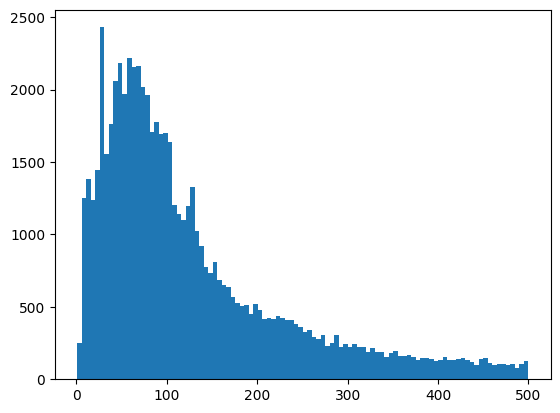

Remaining datapoints: 0.8685512083316579


In [12]:
filter_articles = no_nans[no_nans["replyType"] != "NOT_ARTICLE"]
inspect_dist(filter_articles["text"].apply(len), threshold=500)

In [13]:
filter_articles[filter_articles["text"].str.len() == 28]

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
197,1rcpjlyyxj8z3,TEXT,NORMAL,https://youtu.be/dfkra9aWbUU,1.0,2022-08-22T14:50:41.179Z,2022-08-22T14:50:41.179Z,2022-08-23T12:16:58.136Z,5895588c4971a901a9cf4c7985cc6629737be6d3d5ca73...,RUMORS_LINE_BOT,...,1rcpjlyyxj8z3,popazYIBv5it-Cx_Q02L,86d6e7d770c3689556b9a1b392a3398e80ecf394762ffb...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-08-24T00:57:01.072Z,2022-08-24T00:57:01.072Z
240,2vrwlb2i18e0h,TEXT,NORMAL,你好！我是黑髮中醫師李君茹，请问你是想改善白发的症状吗？,1.0,2021-09-13T05:41:49.943Z,2021-09-13T05:41:49.943Z,2021-12-12T03:28:00.230Z,02ba17531c0858aa99ed8799d3acdead23366a6a9ad610...,RUMORS_LINE_BOT,...,2vrwlb2i18e0h,mEKGEXsBgBgcuemXMur5,096268ed177f92c93c962e612a6c59d86db8bb3867b245...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-09T05:18:38.241Z,2022-09-09T05:18:38.241Z
272,32n7ih4e4cabq,TEXT,NORMAL,https://youtu.be/cvy8Ha1iYr8,1.0,2022-08-20T07:44:34.482Z,2022-08-20T07:44:34.482Z,2022-08-20T07:44:34.509Z,71ce73705459f10b43999032195236d360194e188d6e81...,RUMORS_LINE_BOT,...,32n7ih4e4cabq,EIr5x4IBv5it-Cx_1kjw,86d6e7d770c3689556b9a1b392a3398e80ecf394762ffb...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-08-22T23:53:35.734Z,2022-08-22T23:53:35.734Z
361,2dri8uwzhq3cb,TEXT,NORMAL,https://www.xmtrader.net/tw/,1.0,2021-03-23T04:01:49.239Z,2021-03-23T04:01:49.239Z,2021-04-11T07:32:51.854Z,21dc43061a9de6579d38e0139db31978118e5e055e3f52...,RUMORS_LINE_BOT,...,2dri8uwzhq3cb,bVOJvIEBZ4FY5vnA3Y4I,86d6e7d770c3689556b9a1b392a3398e80ecf394762ffb...,0.0,2.0,RUMOR,WEBSITE,NORMAL,2022-07-02T01:32:40.589Z,2022-07-02T01:32:40.589Z
398,2i74ymhys5l85,TEXT,NORMAL,https://youtu.be/VWm--YH0U1s,1.0,2020-04-24T02:56:39.327Z,2020-04-24T02:56:39.327Z,2020-04-24T14:09:15.823Z,e8a78758ebbfb1cf5d53579664a763e2da8b31f2972226...,RUMORS_LINE_BOT,...,2i74ymhys5l85,bBS8rHEBrhVJn3LNfSS6,86d6e7d770c3689556b9a1b392a3398e80ecf394762ffb...,0.0,5.0,RUMOR,WEBSITE,NORMAL,2020-04-24T15:09:26.345Z,2020-04-24T15:09:26.345Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166011,2nn9hdhq0i5ds,TEXT,NORMAL,全世界都知道賴清德養小三叫莊雅芬、生了一個私生子叫賴庭瀚,1.0,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.298Z,ba2fe1c2638275dde1c566a384aa2f4d9f88940ef61191...,RUMORS_LINE_BOT,...,2nn9hdhq0i5ds,5Pch1YwBAjOeMOklwxU3,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,0.0,2.0,RUMOR,WEBSITE,NORMAL,2024-01-04T15:40:08.890Z,2024-01-04T15:40:08.890Z
166639,2ydtrd7w2lc8o,TEXT,NORMAL,https://youtu.be/2xO9PUcCcfs,1.0,2020-11-18T00:27:33.268Z,2020-11-18T00:27:33.268Z,2020-11-18T00:27:58.030Z,9fac7663bdb9f34bbee84ce9fd79b766b809e8710bf99b...,RUMORS_LINE_BOT,...,2ydtrd7w2lc8o,8Tqn22UBbZnN2I-EV51z,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,15.0,OPINIONATED,WEBSITE,NORMAL,2020-11-18T03:10:27.661Z,2020-11-18T03:10:27.661Z
167782,PPd8BY0BAjOeMOklr1aF,VIDEO,NORMAL,賴清德一樣\n柯文哲一樣\n誒那個柯文哲怎麼記下那個賴清德呢,1.0,2024-01-14T01:01:13.987Z,2024-01-14T01:01:13.987Z,2024-01-14T01:01:13.999Z,dc9571b65d738aa7ecf0c6367a7cc3a43103807f8df716...,RUMORS_LINE_BOT,...,PPd8BY0BAjOeMOklr1aF,Q_exBo0BAjOeMOkliliq,fd3e3b1b26903227de9cd115a3f89e3c2a1fbb60d2252c...,0.0,0.0,RUMOR,WEBSITE,NORMAL,2024-01-14T06:38:35.181Z,2024-01-14T06:38:35.181Z
168960,h9io4zcc5wbg,TEXT,NORMAL,了解 先自我介紹一下 我是淞瑋包裝材料行徵工代表：葉佳倩,1.0,2024-01-20T06:44:26.971Z,2024-01-20T06:44:26.971Z,2024-01-25T08:35:51.328Z,17295e1f0761fd28c74ff00632d2dd29dbf37baf42f8f0...,RUMORS_LINE_BOT,...,h9io4zcc5wbg,qPc9Qo0BAjOeMOklzqEu,7708d900e0a9d4a92ad69381b1e0782338787e027954ce...,0.0,0.0,RUMOR,WEBSITE,NORMAL,2024-01-25T20:09:23.249Z,2024-01-25T20:09:23.249Z


In [14]:
def remove_url(text: str):
    text = re.sub(r"https?://(?:www\.)?\w+(?:\.\w+)+(?:/\S*)?", "", text)
    if len(text) == 0:
        text = pd.NA
    return text

In [15]:
no_urls = filter_articles.copy()
no_urls["text"] = no_urls["text"].apply(remove_url)
no_urls = no_urls[no_urls['text'] != "<NA>"]
#no_urls = no_urls.dropna(subset=["text"])
no_urls.head()

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
0,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,14h550ymn3m3u,6oo8DYMBv5it-Cx_8405,6892d0026181e95d034bf8781025afbf395d57cc88ac05...,0.0,3.0,RUMOR,WEBSITE,NORMAL,2022-09-05T10:40:41.789Z,2022-09-05T10:40:41.789Z
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班\n\n2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,oupi0eu9aocr,MYotCYMBv5it-Cx_gIpH,fc9652aa205dab75e19ecff420945e95aa3909a54b0d9a...,0.0,1.0,OPINIONATED,WEBSITE,NORMAL,2022-09-04T15:45:20.464Z,2022-09-04T15:45:20.464Z
3,my5ep5z69tql,TEXT,NORMAL,你好👱🏻‍♀️\n\n簡單跟你說一下公司工作內容：\n我們是做購物系統訂單的工作，主要就是增...,1.0,2022-08-11T20:53:15.644Z,2022-08-11T20:53:15.644Z,2022-09-07T11:02:00.344Z,8a8a319bea0b3bff580d8507ae6470ba37e87791171886...,RUMORS_LINE_BOT,...,my5ep5z69tql,y22DlmsBFV14knB4ErTJ,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:59:48.921Z,2022-09-07T22:59:48.921Z
4,3dnh713ikpf3c,TEXT,NORMAL,先和你簡單介紹\n我們誠徵線上打工小幫手\n工作內容有：聽寫打字、頁面排版、商品評論刷流量、...,1.0,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.761Z,47e90b2538a5615b323f50571b77d91f7f105e55684aa1...,RUMORS_LINE_BOT,...,3dnh713ikpf3c,H8Hz4WsBqwaEkHKwtyFm,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T23:00:19.207Z,2022-09-07T23:00:19.207Z
5,2m9drd702d8l1,TEXT,NORMAL,【樂天貸款】尊敬的用戶，您的借款額度已提升到50萬，當天領取當天到賬，及時添加專員提現LIN...,1.0,2022-09-07T11:56:37.690Z,2022-09-07T11:56:37.690Z,2022-09-07T11:56:37.713Z,c8d02860e8fdeea921585710dba8e3eb8da914b57f3ad4...,RUMORS_LINE_BOT,...,2m9drd702d8l1,moopGoMBv5it-Cx_FZnG,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:54:03.723Z,2022-09-07T22:54:03.723Z


In [16]:

tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# def encoder(sentences: list):
#     encoded_dict = tokenizer.batch_encode_plus(
#         sentences,
#         add_special_tokens=False,
#         return_tensors="np",
#         max_length=712,
#         padding="max_length",
#         truncation=False
#     )
#     return encoded_dict["input_ids"]


In [17]:
listed = no_urls[['text','replyType']].dropna().copy()
listed['replyType'] = listed['replyType'].map(lambda x: x.replace("NOT_RUMOR", "0"))
listed['replyType'] = listed['replyType'].map(lambda x: x.replace("OPINIONATED", "1"))
listed['replyType'] = listed['replyType'].map(lambda x: x.replace("RUMOR", "2"))
listed['replyType'] = listed['replyType'].astype(int)
listed['text'] = listed['text'].map(lambda x: torch.Tensor(tokenizer(x)['input_ids']))
listed['replyType'] = listed['replyType'].map(lambda x: torch.tensor(x))
padded = torch.nn.utils.rnn.pad_sequence(listed['text'], batch_first=True, padding_value=0)
zipped = list(zip(padded, listed['replyType']))

Token indices sequence length is longer than the specified maximum sequence length for this model (5111 > 512). Running this sequence through the model will result in indexing errors


In [18]:
# def k_fold_split_data(dataset, batch_size, k=5):
#     n = len(dataset)
#     fold_size = n // k
#     folds = []

#     def collate_fn(data):
#         tensors, targets = zip(*data)
#         features = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
#         targets = torch.stack(targets)
#         return features, targets

#     for i in range(k):
#         start = i * fold_size
#         end = (i + 1) * fold_size if i < k - 1 else n
#         folds.append(torch.utils.data.Subset(dataset, range(start, end)))

#     dataloaders = []
#     for i in range(k):
#         validation_dataset = folds[i]
#         train_folds = [folds[j] for j in range(k) if j != i]
#         train_dataset = torch.utils.data.ConcatDataset(train_folds)

#         y = torch.tensor([label for _, label in train_dataset], dtype=torch.long)

#         global class_weights
#         class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
#         class_weights = torch.tensor(class_weights, dtype=torch.float)

#         train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#         validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#         dataloaders.append((train_dataloader, validation_dataloader))

#     return dataloaders

In [19]:
def randomly_split_data(dataset, batch_size):
    

    #generator = torch.Generator().manual_seed(42)
    #train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], generator=generator)
    train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

    y = torch.tensor([label for _, label in dataset], dtype=torch.long)

    def collate_fn(data):
        tensors, targets = zip(*data)
        features = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
        targets = torch.stack(targets)
        return features, targets

    global class_weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, validation_dataloader, test_dataloader

In [20]:
class TuneableModel(torch.nn.Module):
    def __init__(self, input_size, layer_size, dropout_rate, n_layers):
        super(TuneableModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=layer_size, bidirectional=True, 
                                  num_layers=n_layers, batch_first=True, dropout=dropout_rate)
        self.output_layer = torch.nn.Linear(layer_size, 3)
        self.batchnorm = torch.nn.BatchNorm1d(layer_size)
        self.activation = torch.nn.ReLU()
        self.linear = torch.nn.Linear(layer_size*2, layer_size)

    def forward(self, x):
        x = self.lstm(x)
        x = self.activation(x[0])
        x = self.linear(x)
        x = self.batchnorm(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

In [21]:
def train_test(model, dataloader, optimizer, training="train"):
   
    loss_function = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

    if training == "train":
        model.train()
    elif training == "validation":
        model.eval()
    elif training == "test":
        model.eval()
    else:
        raise ValueError("training argument must be either 'train', 'validation' or 'test'")
        
    cumulative_loss = 0
    prediction_list = []
    label_list = []
    for sample in tqdm(dataloader):
        input, targets = sample[0].float().to(device), sample[1].type(torch.LongTensor).to(device)
        output = model(input).to(device)
        loss_value = loss_function(output, targets)
        cumulative_loss += loss_value.item()

        if training == "train":
            optimizer.zero_grad()
            loss_value.sum().backward()
            optimizer.step()
            
        predictions = output.to('cpu').detach().numpy().argmax(axis=1)
        target_labels = sample[1]
        prediction_list.extend(predictions)
        label_list.extend(target_labels)
    #f1 = f1_score(label_list, prediction_list)
    accuracy = accuracy_score(label_list, prediction_list)
    #confusion = confusion_matrix(label_list, prediction_list)

    return cumulative_loss, accuracy#, f1, confusion

In [25]:
# Training sample
def evaluate(params):
    dropout, hidden_size, learning_rate, batch_size, n_hidden = params

    max_epochs = 1000
    max_patience = 5
    seed = 42

    accuracies = []
    f1s = []
    train_dataloader, validation_dataloader, test_dataloader = randomly_split_data(dataset, batch_size)
    #dataloaders = k_fold_split_data(dataset, batch_size, k=5)
    # train_dataloader, validation_dataloader = dataloader[0], dataloader[1]
    # test_dataloader = dataloader[1]
    PATH = "model_.pt"
    last_loss = 1000000
    torch.manual_seed(seed)
    input_size = train_dataloader.dataset[0][0].size()[0]
    model = TuneableModel(input_size, hidden_size, dropout, n_hidden)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(max_epochs):
        # training
        train_loss, train_accuracy = train_test(model, train_dataloader, optimizer, training="train")
        train_loss, train_accuracy = train_loss, round(train_accuracy, 4)
        # validation at end of epoch
        validation_loss, validation_accuracy = train_test(model, validation_dataloader, optimizer, training="validation")
        validation_loss, validation_accuracy = validation_loss, round(validation_accuracy, 4)
        if validation_loss < last_loss:
            last_loss = validation_loss
            current_patience = 0
        else:
            if current_patience == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': last_loss,
                    }, PATH)
            current_patience += 1
        if current_patience == max_patience:
            break   
        if epoch % 1 == 0:
            print(f"Epoch {epoch} validation loss: {validation_loss} validation accuracy: {validation_accuracy*100}%")
    # Testing once patience is reached
    torch.manual_seed(seed)
    model = TuneableModel(input_size, hidden_size, dropout, n_hidden)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    test_loss, test_accuracy = train_test(model, test_dataloader, optimizer, training="test")
    test_loss, test_accuracy = test_loss, test_accuracy
    #print(f"Model {i} at epoch {checkpoint['epoch']} test results: accuracy: {test_accuracy*100}% f1: {test_f1}")
    # accuracies.append(test_accuracy)
    # f1s.append(test_f1)
    #print(test_confusion)

    return round(test_accuracy*100, )
    # print(f"Average accuracy: {round(np.mean(accuracies), 2)}%")
    # print(f"Average f1: {round(np.mean(f1s), 2)}")


In [23]:
dataset = zipped


In [27]:
params = (0.0, 256, 0.1, 256, 4)
accuracy, f1 = evaluate(params)
print(f"10-fold average accuracy: {accuracy}%, F1: {f1}")

100%|██████████| 27/27 [00:01<00:00, 17.52it/s]


Epoch 0 validation loss: 29.66617774963379 validation accuracy: 22.03%


100%|██████████| 27/27 [00:01<00:00, 16.38it/s]


Epoch 1 validation loss: 29.675812244415283 validation accuracy: 14.99%


100%|██████████| 27/27 [00:01<00:00, 14.07it/s]


Epoch 2 validation loss: 29.692907094955444 validation accuracy: 62.86000000000001%


100%|██████████| 27/27 [00:01<00:00, 17.53it/s]


Epoch 3 validation loss: 29.75939631462097 validation accuracy: 15.02%


100%|██████████| 27/27 [00:01<00:00, 18.15it/s]


Epoch 4 validation loss: 29.795060634613037 validation accuracy: 22.12%


100%|██████████| 27/27 [00:01<00:00, 16.30it/s]


TypeError: cannot unpack non-iterable int object